In [61]:
import pandas as pd
import numpy as np

import datetime 
import time

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate,SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.utils import shuffle


In [62]:
!unzip -n archive.zip

Archive:  archive.zip


In [63]:
events_df = pd.read_csv('./events.csv')

events_df.head()
events_df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [99]:
events_df = pd.read_csv('./events.csv')

events_df.head()
# events_df.shape


events_df.event.value_counts()
# events_df.nunique()
#buying as 3,add_to_cart=2,view=1



# events_df.dropna(inplace=True)
events_df['event_encode']=events_df['event'].map({
    'view':0.1,'addtocart':1,'transaction':10
})
# events_df.drop_duplicates(subset=
                          # ['visitorid','itemid']).shape[0]/events_df.shape[0]

df_events=events_df.groupby(['visitorid','itemid'])['event_encode'].sum().to_frame('rating').reset_index()



df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,1,10,1000],right=False,
                      labels=[1,2,3],
                      include_lowest=True)
#Views,addt0cart,transaction

df_events.loc[:,'cum_rating']=pd.cut(df_events['rating'],bins=[0.1,0.2,1,10,1000],right=False,
                      labels=[1,2,3,4],
                      include_lowest=True)
df_events.cum_rating.value_counts()
df_events.loc[:,'cum_rating']=df_events.loc[:,'cum_rating'].astype(int)
#just_views,higher_views,addt0cart,transaction

In [100]:
current_user_id = 0
custom_user_map = {} # old user id > new user id
def map_user_id(row):
  global current_user_id, custom_user_map
  old_user_id = row['visitorid']
  if old_user_id not in custom_user_map:
    custom_user_map[old_user_id] = current_user_id
    current_user_id += 1
  return custom_user_map[old_user_id]

df_events['new_vis_id'] = df_events.apply(map_user_id, axis=1)


current_item_id = 0
custom_item_map = {} # old user id > new user id
def map_user_id(row):
  global current_item_id, custom_item_map
  old_item_id = row['itemid']
  if old_item_id not in custom_item_map:
    custom_item_map[old_item_id] = current_item_id
    current_item_id += 1
  return custom_item_map[old_item_id]

df_events['new_item_id'] = df_events.apply(map_user_id, axis=1)

assert(df_events['new_item_id'].nunique()==(df_events['new_item_id'].max()-df_events['new_item_id'].min() +1))
assert(df_events['new_vis_id'].nunique()==(df_events['new_vis_id'].max()-df_events['new_vis_id'].min() +1))#therefore we have contnious arrangement of unique values

In [103]:
user_ids = df_events['new_vis_id'].values
item_ids = df_events['new_item_id'].values
ratings = df_events['cum_rating'].values

N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
print(N,M)

1407580 235061


In [107]:
df_events=df_events[['new_vis_id','new_item_id','cum_rating']]


df_events=pd.concat([df_events[['new_vis_id','new_item_id']].shift(i).rename(columns={c:c+'_'+str(i) for c in ['new_vis_id','new_item_id']}) for i in range(5)]
          +[df_events['cum_rating']],axis=1)

df_events.dropna(inplace=True)

df_events=df_events.astype(int)
df_events.reset_index(inplace=True,drop=True)
df_events

,new_vis_id_0,new_item_id_0,new_vis_id_1,new_item_id_1,new_vis_id_2,new_item_id_2,new_vis_id_3,new_item_id_3,new_vis_id_4,new_item_id_4,cum_rating
0,2,4,1,3,0,2,0,1,0,0,2
1,2,5,2,4,1,3,0,2,0,1,1
2,2,6,2,5,2,4,1,3,0,2,2
3,2,7,2,6,2,5,2,4,1,3,2
4,3,8,2,7,2,6,2,5,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2145170,1407575,92255,1407574,19144,1407573,5904,1407573,46824,1407573,235060,1
2145171,1407576,36504,1407575,92255,1407574,19144,1407573,5904,1407573,46824,1
2145172,1407577,61448,1407576,36504,1407575,92255,1407574,19144,1407573,5904,1
2145173,1407578,22299,1407577,61448,1407576,36504,1407575,92255,1407574,19144,1


In [108]:
df_events=df_events.dropna(how='any')
# df_events=df_events.sample(frac=0.4)

In [70]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id_0'].values
item_ids = df_events['new_item_id_0'].values
ratings = df_events['cum_rating'].values

# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(item_ids))

# Set embedding dimension
K = 10
print(N,M)

user_ids = df_events[[i for i in df_events.columns if 'new_vis_id' in i]].values[:,:2]
# item_ids = df_events[[i for i in df_events.columns if 'new_item_id' in i]].values
# ratings will remain the same 


user_ids.shape,item_ids.shape,ratings.shape

1407578 235061


((2145175, 2), (2145175,), (2145175,))

In [76]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate,SimpleRNN


In [82]:
# Make a neural network

K = 10


# User input
u = Input(shape=(2,))

# Item input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 5, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings

u_rnn=SimpleRNN(2,activation='relu')(u_emb)
u_emb = Flatten()(u_rnn) # now it's (num_samples, 2K)
m_emb = Flatten()(m_emb) # now it's (num_samples, 2K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


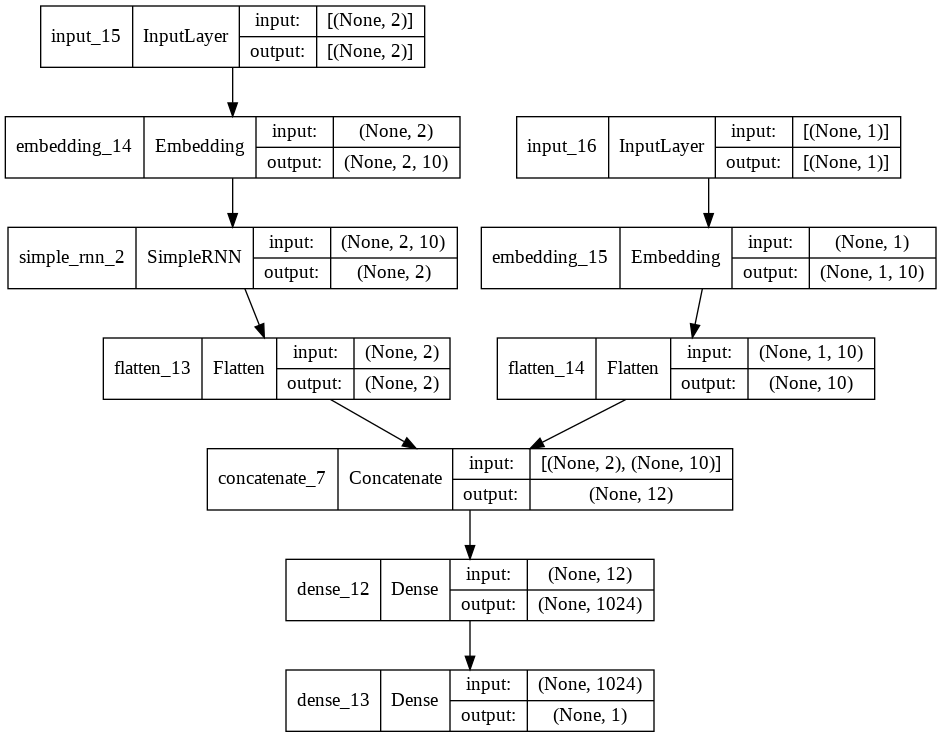

In [83]:
from tensorflow.keras.utils import plot_model

plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

In [84]:
# split the data
#will create hold out set later, need to devise a way
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# # center the ratings
# avg_rating = train_ratings.mean()
# train_ratings = train_ratings - avg_rating
# test_ratings = test_ratings - avg_rating

In [85]:
r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=15,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/15
1781/1781 - 16s - loss: 0.2650 - val_loss: 0.2638 - 16s/epoch - 9ms/step
Epoch 2/15
1781/1781 - 15s - loss: 0.2621 - val_loss: 0.2636 - 15s/epoch - 8ms/step
Epoch 3/15
1781/1781 - 15s - loss: 0.2621 - val_loss: 0.2634 - 15s/epoch - 8ms/step
Epoch 4/15
1781/1781 - 14s - loss: 0.2597 - val_loss: 0.2588 - 14s/epoch - 8ms/step
Epoch 5/15
1781/1781 - 15s - loss: 0.2568 - val_loss: 0.2608 - 15s/epoch - 8ms/step
Epoch 6/15
1781/1781 - 15s - loss: 0.2539 - val_loss: 0.2694 - 15s/epoch - 8ms/step
Epoch 7/15
1781/1781 - 15s - loss: 0.2504 - val_loss: 0.2873 - 15s/epoch - 8ms/step
Epoch 8/15
1781/1781 - 14s - loss: 0.2469 - val_loss: 0.3085 - 14s/epoch - 8ms/step
Epoch 9/15
1781/1781 - 15s - loss: 0.2432 - val_loss: 0.3100 - 15s/epoch - 8ms/step
Epoch 10/15
1781/1781 - 15s - loss: 0.2373 - val_loss: 0.3431 - 15s/epoch - 8ms/step
Epoch 11/15
1781/1781 - 15s - loss: 0.2306 - val_loss: 0.3276 - 15s/epoch - 8ms/step
Epoch 12/15
1781/1781 - 15s - loss: 0.2238 - val_loss: 0.3035 - 15s/epoch 

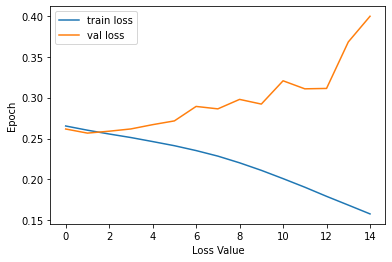

In [75]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="val loss")
plt.xlabel('Loss Value')
plt.ylabel('Epoch')
plt.legend()
plt.show()

# Association matrix for users

In [104]:
# Make a neural network

K = 10


# User input
u = Input(shape=(5,))

# Item input
m = Input(shape=(1,))

# User embedding
u_emb = Embedding(N, K)(u) # output is (num_samples, 5, K)

# Movie embedding
m_emb = Embedding(M, K)(m) # output is (num_samples, 1, K)#because of definition of embedder matrix

#Architecture of the model
# Flatten both embeddings

u_pseudo_gnn=Flatten()(u_emb)
u_pseudo_gnn = Dense(216, activation='relu')(u_pseudo_gnn)
u_pseudo_gnn = Dense(10)(u_pseudo_gnn)


u_emb = Flatten()(u_pseudo_gnn) # now it's (num_samples, 2K)
m_emb = Flatten()(m_emb) # now it's (num_samples, 2K)

# Concatenate user-movie embeddings into a feature vector
x = Concatenate()([u_emb, m_emb]) # now it's (num_samples, 2K)

# Now that we have a feature vector, it's just a regular ANN
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)


# Build the model and compile
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


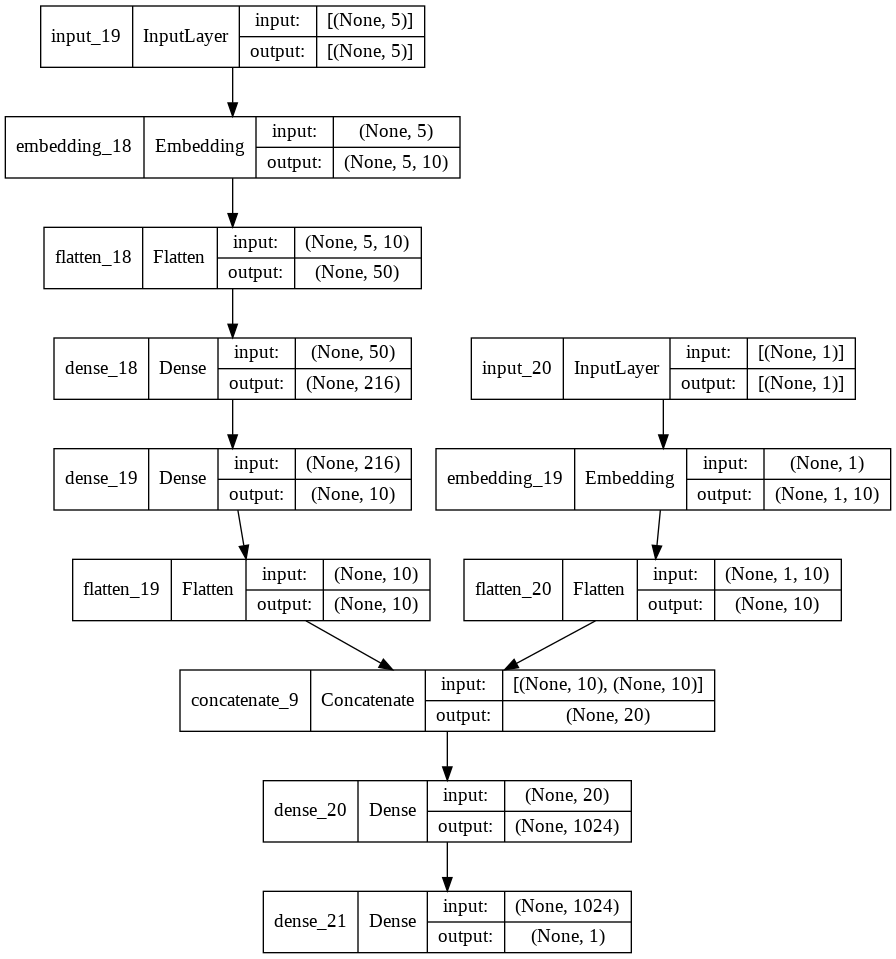

In [105]:
from tensorflow.keras.utils import plot_model

plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

In [97]:
df_events['new_vis_id_0'].values

array([      2,       2,       2, ..., 1407577, 1407578, 1407579])

In [109]:
df_events.describe()
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df_events['new_vis_id_0'].values
item_ids = df_events['new_item_id_0'].values
ratings = df_events['cum_rating'].values



user_ids = df_events[[i for i in df_events.columns if 'new_vis_id' in i]].values[:,:5]
# item_ids = df_events[[i for i in df_events.columns if 'new_item_id' in i]].values
# ratings will remain the same 

# user_ids.shape,item_ids.shape,ratings.shape

In [110]:
user_ids, item_ids, ratings = shuffle(user_ids, item_ids, ratings)
Ntrain = int(0.85 * len(ratings))

train_user = user_ids[:Ntrain]
train_item = item_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_item = item_ids[Ntrain:]
test_ratings = ratings[Ntrain:]


train_user.shape,test_ratings.shape

((1823398, 5), (321777,))

In [111]:


r = model.fit(
  x=[train_user, train_item],
  y=train_ratings,
  epochs=3,
  batch_size=1024,
  verbose=2, # goes a little faster when you don't print the progress bar
  validation_data=([test_user, test_ratings], test_ratings),
)

Epoch 1/3
1781/1781 - 12s - loss: 0.2650 - val_loss: 0.2629 - 12s/epoch - 6ms/step
Epoch 2/3
1781/1781 - 11s - loss: 0.2597 - val_loss: 0.2582 - 11s/epoch - 6ms/step
Epoch 3/3
1781/1781 - 11s - loss: 0.2550 - val_loss: 0.2569 - 11s/epoch - 6ms/step
